# Orders and payments

We start the data analysis by looking at the orders and payments made by customers of the Olist store. In this notebook I will try to find answers to such questions:
- How many orders were and what was their distribution over time?
- Orders of what value have not been delivered to the customer?
- Which product categories generated the most revenue?
- What revenue did the store generate over the entire period (2016-18)?
- What was the average order value and what is their distribution?

Importing Python libraries in order to make some possible visualizations.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

To create SQL queries we will use the so-called Jupyter line magics. First you need to connect to the database.

In [2]:
%load_ext sql
%sql sqlite:///data/olist.db

'Connected: @data/olist.db'

Let's check what tables are in the database

In [3]:
%%sql
SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:///data/olist.db
Done.


name
sellers
orders
order_payments
order_items
customers
products
products_translation
reviews


For the analysis in this notebook, we will use the tables:
- 'orders'
- 'order_items'
- 'order_payments
- 'products'
- 'products_translation'

Below is a brief overview of what the data looks like:

In [11]:
%%sql
SELECT * FROM orders LIMIT 3;

 * sqlite:///data/olist.db
Done.


order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [12]:
%%sql
SELECT * FROM order_items LIMIT 3;

 * sqlite:///data/olist.db
Done.


order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [13]:
%%sql
SELECT * FROM order_payments LIMIT 3;

 * sqlite:///data/olist.db
Done.


order_id,payment_sequential,payment_type,payment_installments,payment_value
b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


In [14]:
%%sql
SELECT * FROM products LIMIT 3;

 * sqlite:///data/olist.db
Done.


product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40,287,1,225,16,10,14
3aa071139cb16b67ca9e5dea641aaa2f,artes,44,276,1,1000,30,18,20
96bd76ec8810374ed1b65e291975717f,esporte_lazer,46,250,1,154,18,9,15


In [15]:
%%sql
SELECT * FROM products_translation LIMIT 3;

 * sqlite:///data/olist.db
Done.


product_category_name,product_category_name_english
beleza_saude,health_beauty
informatica_acessorios,computers_accessories
automotivo,auto


### How many orders were and what was their distribution over time?

How many orders were there in the entire period?

In [41]:
%%sql
SELECT COUNT(order_id) FROM orders;

 * sqlite:///olist.db
Done.


COUNT(order_id)
99441


When did the first and last orders occur?

In [44]:
%%sql
SELECT min(datetime(order_purchase_timestamp)) AS start_date, max(datetime(order_purchase_timestamp)) AS end_date FROM orders;

 * sqlite:///olist.db
Done.


start_date,end_date
2016-09-04 21:15:19,2018-10-17 17:30:18


Let's check what was the number of orders broken down into the following months.

In [54]:
%%sql
SELECT STRFTIME("%Y-%m",order_purchase_timestamp) AS date, COUNT(order_id) AS orders_number FROM orders
GROUP BY STRFTIME("%Y-%m",order_purchase_timestamp);

 * sqlite:///olist.db
Done.


date,orders_number
2016-09,4
2016-10,324
2016-12,1
2017-01,800
2017-02,1780
2017-03,2682
2017-04,2404
2017-05,3700
2017-06,3245
2017-07,4026


Using pandas and the seaborn library, we can make a simple visualization of the number of orders by month very quickly.

 * sqlite:///olist.db
Done.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, '2016-09'),
  Text(1, 0, '2016-10'),
  Text(2, 0, '2016-12'),
  Text(3, 0, '2017-01'),
  Text(4, 0, '2017-02'),
  Text(5, 0, '2017-03'),
  Text(6, 0, '2017-04'),
  Text(7, 0, '2017-05'),
  Text(8, 0, '2017-06'),
  Text(9, 0, '2017-07'),
  Text(10, 0, '2017-08'),
  Text(11, 0, '2017-09'),
  Text(12, 0, '2017-10'),
  Text(13, 0, '2017-11'),
  Text(14, 0, '2017-12'),
  Text(15, 0, '2018-01'),
  Text(16, 0, '2018-02'),
  Text(17, 0, '2018-03'),
  Text(18, 0, '2018-04'),
  Text(19, 0, '2018-05'),
  Text(20, 0, '2018-06'),
  Text(21, 0, '2018-07'),
  Text(22, 0, '2018-08'),
  Text(23, 0, '2018-09'),
  Text(24, 0, '2018-10')])

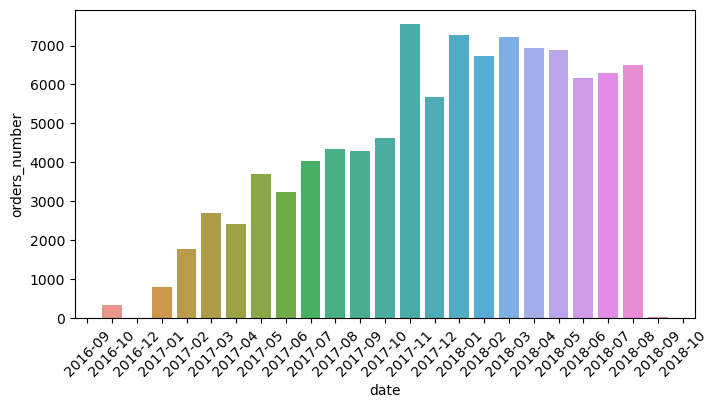

In [63]:
data = %sql SELECT STRFTIME("%Y-%m",order_purchase_timestamp) AS date, COUNT(order_id) AS orders_number FROM orders \
GROUP BY STRFTIME("%Y-%m",order_purchase_timestamp);

plt.figure(figsize = (8,4))
sns.barplot(data.DataFrame(), x='date', y='orders_number')
plt.xticks(rotation=45)

### Orders of what value have not been delivered to the customer?

In the 'orders' table there is an 'order_status' column which simply describes the status of each order. Below, the number of orders depending on the status in the entire data range.

In [70]:
%%sql
SELECT order_status, COUNT(order_id) AS count FROM orders
GROUP BY order_status
ORDER BY count DESC;

 * sqlite:///olist.db
Done.


order_status,count
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


As you can see, the vast majority of orders have been delivered. Let's check what value (payment_value item from the 'order_payments' table) is for all orders with a status other than *delivered*.

In [13]:
%%sql
SELECT ROUND(SUM(order_payments.payment_value),2) AS payment_total FROM order_payments
LEFT JOIN orders ON order_payments.order_id=orders.order_id
WHERE orders.order_status!='delivered' ;

 * sqlite:///olist.db
Done.


payment_total
586410.35


Breakdown by total value of delivered and non-delivered orders.

In [21]:
%%sql
SELECT a.order_status AS order_status, ROUND(SUM(a.payment_value),2) AS total_sum FROM 
(SELECT order_payments.payment_value,
CASE
    WHEN orders.order_status!='delivered' THEN 'not delivered'
    ELSE 'delivered'
END order_status
FROM order_payments
LEFT JOIN orders ON order_payments.order_id=orders.order_id) AS a
GROUP BY a.order_status
;

 * sqlite:///olist.db
Done.


order_status,total_sum
delivered,15422461.77
not delivered,586410.35


### Which product categories generated the most revenue?

Each order contains information about the purchased product (*product_id*). Thanks to this information, you can read the name of the product category from the 'products' table and translate it into English by connecting to the 'products_translation' table.

Below is a table with the following information for each product category:
- avg_price - average price of the product
- avg_freight - average shipment price
- avg_order - average order value
- orders_count - total number of all orders
- total_order_sum - total revenue

In [35]:
%%sql
SELECT products_translation.product_category_name_english AS category, ROUND(AVG(order_items.price),2) AS avg_price, ROUND(AVG(order_items.freight_value),2) AS avg_freight, ROUND(AVG(order_payments.payment_value),2) AS avg_order, COUNT(order_items.order_id) AS orders_count, ROUND(SUM(order_payments.payment_value),2) AS total_order_sum FROM order_items 
LEFT JOIN products ON order_items.product_id = products.product_id
LEFT JOIN order_payments ON order_items.order_id = order_payments.order_id
LEFT JOIN products_translation ON products.product_category_name=products_translation.product_category_name
GROUP BY products_translation.product_category_name_english
ORDER BY total_order_sum DESC
LIMIT 20;

 * sqlite:///olist.db
Done.


category,avg_price,avg_freight,avg_order,orders_count,total_order_sum
bed_bath_table,92.41,18.42,144.85,11823,1712553.67
health_beauty,130.07,18.9,166.2,9975,1657373.12
computers_accessories,116.59,18.95,196.16,8082,1585330.45
furniture_decor,87.5,20.76,163.56,8744,1430176.39
watches_gifts,202.09,16.83,230.48,6201,1429216.68
sports_leisure,114.48,19.51,155.63,8945,1392127.56
housewares,90.63,20.97,148.85,7355,1094758.13
auto,140.84,21.85,194.63,4379,852294.33
garden_tools,113.3,23.09,183.27,4574,838280.75
cool_stuff,166.12,22.03,195.56,3987,779698.0


### What revenue did the store generate over the entire period (2016-18)?

According to the database documentation, the order value is calculated by adding the price and shipping (*freight_value*) values. Below is the sum of all orders broken down into the sum of the product price and the shipment itself. The shipping costs alone amounted to over RBL 2 million.

In [43]:
%%sql
SELECT ROUND(SUM(price)+SUM(freight_value),2) AS sum_total, ROUND(SUM(price),2) AS price_total, ROUND(SUM(freight_value),2) AS freight_total FROM order_items;

 * sqlite:///olist.db
Done.


sum_total,price_total,freight_total
15843553.24,13591643.7,2251909.54


If we calculate the sum of payments made, it turns out to be different from the previously calculated value.  
Unfortunately, I was unable to find the reason for this discrepancy.

In [45]:
%%sql
SELECT ROUND(SUM(payment_value),2) AS payment_total FROM order_payments;

 * sqlite:///olist.db
Done.


payment_total
16008872.12


Breakdown of the value of all orders broken down into subsequent years of the store's operation.

In [4]:
%%sql
SELECT STRFTIME("%Y",orders.order_purchase_timestamp) AS year, ROUND(SUM(a.total_sum),2) AS total_revenue FROM
(SELECT order_id, payment_value as total_sum FROM order_payments) AS a
JOIN orders ON a.order_id=orders.order_id
WHERE orders.order_status='delivered'
GROUP BY STRFTIME("%Y",orders.order_purchase_timestamp)
;

 * sqlite:///olist.db
Done.


year,total_revenue
2016,46586.33
2017,6922900.24
2018,8452975.2


### What was the average order value and what is their distribution?

Let's check what is the average value of a single order and the median of all orders.

In [7]:
%%sql
SELECT ROUND(AVG(payment_value),2) AS avg_order, (SELECT payment_value FROM order_payments ORDER BY payment_value LIMIT 1 OFFSET (SELECT COUNT(*) FROM order_payments) / 2) AS median_order 
FROM order_payments;

 * sqlite:///data/olist.db
Done.


avg_order,median_order
154.1,100.0


By selecting the payment value from the 'payment_value' column, we can easily create a histogram with the distribution of order values.  
The chart has been trimmed to the 0-1000 range because it has a very long tail with single high payments.

 * sqlite:///data/olist.db
Done.


<AxesSubplot: ylabel='Count'>

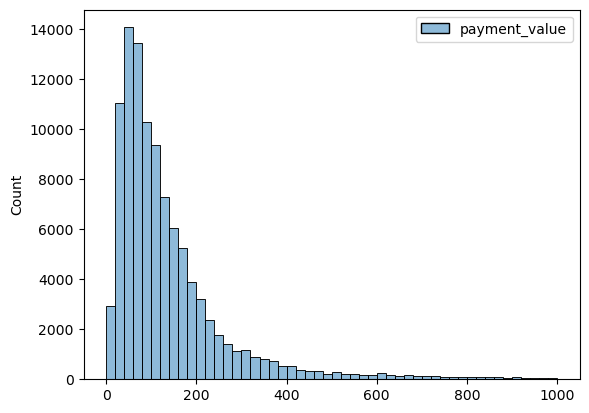

In [9]:
data = %sql SELECT payment_value FROM order_payments;

sns.histplot(data.DataFrame(), bins=50, binrange=[0,1000])
